Code extracted from: https://github.com/vijay033/Noise-Suppression-Auto-Encoder/blob/master/ProcessWav.ipynb

In [1]:
import os
import glob
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import wavfile
from IPython.display import Audio

## Initializations

In [2]:
FFT_LENGTH = 512
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
magnitudeMin = float("inf")
magnitudeMax = float("-inf")
phaseMin = float("inf")
phaseMax = float("-inf")

## Functions

In [3]:
def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

def generateLinearScale(magnitudePixels, phasePixels, magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    height = magnitudePixels.shape[0]
    width = magnitudePixels.shape[1]
    magnitudeRange = magnitudeMax - magnitudeMin
    phaseRange = phaseMax - phaseMin
    rgbArray = np.zeros((height, width, 3), 'uint8')
    
    for w in range(width):
        for h in range(height):
            magnitudePixels[h,w] = (magnitudePixels[h,w] - magnitudeMin) / (magnitudeRange) * 255 * 2
            magnitudePixels[h,w] = amplifyMagnitudeByLog(magnitudePixels[h,w])
            phasePixels[h,w] = (phasePixels[h,w] - phaseMin) / (phaseRange) * 255
            red = 255 if magnitudePixels[h,w] > 255 else magnitudePixels[h,w]
            green = (magnitudePixels[h,w] - 255) if magnitudePixels[h,w] > 255 else 0
            blue = phasePixels[h,w]
            rgbArray[h,w,0] = int(red)
            rgbArray[h,w,1] = int(green)
            rgbArray[h,w,2] = int(blue)
    return rgbArray

def recoverLinearScale(rgbArray, magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    width = rgbArray.shape[1]
    height = rgbArray.shape[0]
    print(phaseMax,phaseMin)
    magnitudeVals = rgbArray[:,:,0].astype(float) + rgbArray[:,:,1].astype(float)
    phaseVals = rgbArray[:,:,2].astype(float)
    phaseRange = phaseMax - phaseMin
    magnitudeRange = magnitudeMax - magnitudeMin
    
    for w in range(width):
        for h in range(height):
            phaseVals[h,w] = (phaseVals[h,w] / 255 * phaseRange) + phaseMin
            magnitudeVals[h,w] = weakenAmplifiedMagnitude(magnitudeVals[h,w])
            magnitudeVals[h,w] = (magnitudeVals[h,w] / (255*2) * magnitudeRange) + magnitudeMin
    return magnitudeVals, phaseVals

In [4]:
def generateSpectrogramForWave(signal):
    global magnitudeMin
    global magnitudeMax
    global phaseMin
    global phaseMax
    buffer = np.zeros(int(signal.size + WINDOW_STEP - (signal.size % WINDOW_STEP)))
    buffer[0:len(signal)] = signal
    height = int(FFT_LENGTH / 2 + 1)
    width = int(len(buffer) / (WINDOW_STEP) - 1)
    magnitudePixels = np.zeros((height, width))
    phasePixels = np.zeros((height, width))

    for w in range(width):
        buff = np.zeros(FFT_LENGTH)
        stepBuff = buffer[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH]
        # apply hanning window
        stepBuff = stepBuff * np.hanning(WINDOW_LENGTH)
        buff[0:len(stepBuff)] = stepBuff
        #buff now contains windowed signal with step length and padded with zeroes to the end
        fft = np.fft.rfft(buff)
        for h in range(len(fft)):
            #print(buff.shape)
            magnitude = math.sqrt(fft[h].real**2 + fft[h].imag**2)
            if magnitude > magnitudeMax:
                magnitudeMax = magnitude 
            if magnitude < magnitudeMin:
                magnitudeMin = magnitude 

            phase = math.atan2(fft[h].imag, fft[h].real)
            if phase > phaseMax:
                phaseMax = phase
            if phase < phaseMin:
                phaseMin = phase
            magnitudePixels[height-h-1,w] = magnitude
            phasePixels[height-h-1,w] = phase
    rgbArray = generateLinearScale(magnitudePixels, phasePixels, magnitudeMin, magnitudeMax, phaseMin, phaseMax)

    img = Image.fromarray(rgbArray, 'RGB')
    return img

In [5]:
def recoverSignalFromSpectrogram(numpyarray):
    data = np.array(numpyarray, dtype='uint8')
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
        
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    recovered = np.array(recovered,dtype=np.int16)
    
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    return recovered

In [6]:
# Use these initializations for recovery from spectrogram
phaseMax = 3.141592653589793 
phaseMin = -3.141592653589793
magnitudeMax = 2211683.973249525
magnitudeMin = 0.0
rate = 16000

## Usage

In [7]:
files_train = glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_train/*.npy")
files_train_y = glob.glob("/data/csc6621/24-team-c/dataset/LibriNoise_Train_Test_NPY/mat_ytrain/*.npy")

In [8]:
n = 4
X = np.load(files_train[n])
y = np.load(files_train_y[n])

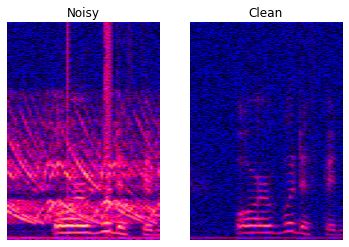

In [9]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X, aspect='auto')
axes[0].set_axis_off()
axes[0].set_title('Noisy')
axes[1].imshow(y, aspect='auto')
axes[1].set_axis_off()
axes[1].set_title('Clean')
plt.show()

In [10]:
X_wav = recoverSignalFromSpectrogram(X)
y_wav = recoverSignalFromSpectrogram(y)

3.141592653589793 -3.141592653589793
3.141592653589793 -3.141592653589793


In [11]:
Audio(data=X_wav, rate=rate)

In [12]:
Audio(data=y_wav, rate=rate)